In [2]:
import sys
sys.path.append("../../")  

In [10]:
from sl_inference_restart.norm_computer.compute_norm_grid import compute_A_phys_eta, single_A_eta_entry, build_A_phys_table_parallel_4D, generate_lens_samples_no_alpha
import numpy as np

In [4]:
# uDM, sigmaDM, beta_DM, xi_DM, n_samples, n_sigma
Aeta = single_A_eta_entry([12.91, 0.37, 2.04, 0, 1000, 3])
print(Aeta)

{'mu_DM': 12.91, 'sigma_DM': 0.37, 'beta_DM': 2.04, 'xi_DM': 0, 'A_phys': 1.1317218922350099}


In [5]:
# def compute_A_phys_eta(mu_DM_cnst, beta_DM, xi_DM, sigma_DM, samples, Mh_range,
#                        zl=0.3, zs=2.0, ms=26.0, sigma_m=0.1, m_lim=26.5):

In [6]:

muDM_grid    = np.linspace(12, 13, 10)      # Δμ = 0.0345
sigmaDM_grid = np.linspace(0.1, 0.5, 10)    # Δσ = 0.0138
betaDM_grid  = np.linspace(1.0, 3.0, 10)    # Δβ = 0.069
xiDM_grid    = 0                            # 固定为 0


build_A_phys_table_parallel_4D(
    muDM_grid, sigmaDM_grid, betaDM_grid, xiDM_grid,
    n_samples=500,
    filename="A_phys_table_4D_test.csv",
    nproc=3,
)

[INFO] 已完成 0 个点，将跳过这些
[INFO] 共需计算 1000 个 A(eta) 点


100%|██████████| 1000/1000 [02:14<00:00,  7.45it/s]


[INFO] 所有任务完成，结果已保存到 A_phys_table_4D_test.csv


In [7]:
import pandas as pd
A_phys_table = pd.read_csv("../tables/A_phys_table_4D_test.csv")

In [8]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd

# 读取表格
df = pd.read_csv("../tables/A_phys_table_4D_test.csv")

# 提取唯一网格点（必须是升序）
mu_grid    = np.sort(df['mu_DM'].unique())
sigma_grid = np.sort(df['sigma_DM'].unique())
beta_grid  = np.sort(df['beta_DM'].unique())
xi_grid    = np.sort(df['xi_DM'].unique())

# reshape A_phys 为 4D 网格
shape = (len(mu_grid), len(sigma_grid), len(beta_grid), len(xi_grid))
A_vals = df.sort_values(['mu_DM', 'sigma_DM', 'beta_DM', 'xi_DM'])['A_phys'].values
A_grid = A_vals.reshape(shape)

# 构造插值器
A_interp = RegularGridInterpolator(
    (mu_grid, sigma_grid, beta_grid, xi_grid),
    A_grid,
    bounds_error=False,
    fill_value=None
)


In [11]:
# from your_module import compute_A_phys_eta, generate_lens_samples_no_alpha

# 举例选一个测试点
mu_test = 12.5
sigma_test = 0.3
beta_test = 1.5
xi_test = 0.0

# 插值器预测值
A_interp_val = A_interp([[mu_test, sigma_test, beta_test, xi_test]])[0]

# 真值（重新生成样本再计算）
samples, Mh_range = generate_lens_samples_no_alpha(
    n_samples=1000, mu_DM=mu_test, sigma_DM=sigma_test
)
A_true = compute_A_phys_eta(mu_test, beta_test, xi_test, sigma_test, samples, Mh_range)

# 比较误差
rel_error = abs(A_interp_val - A_true) / A_true
print(f"A_interp = {A_interp_val:.5f}, A_true = {A_true:.5f}, relative error = {rel_error:.3%}")


A_interp = 1.04067, A_true = 1.18534, relative error = 12.205%


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25554 (\N{CJK UNIFIED IDEOGRAPH-63D2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **

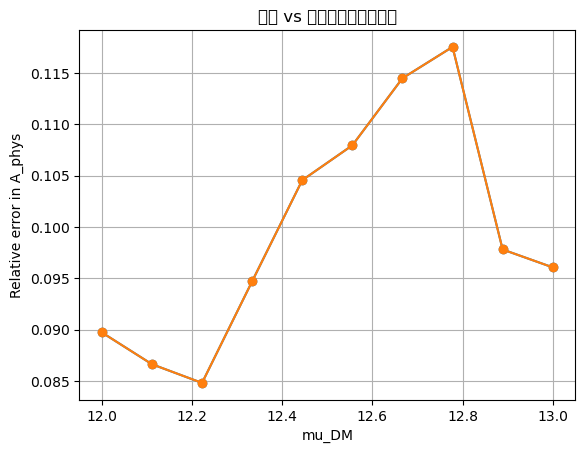

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
mu_tests = np.linspace(12.0, 13.0, 10)
errors = []

for mu in mu_tests:
    samples, Mh_range = generate_lens_samples_no_alpha(n_samples=1000, mu_DM=mu, sigma_DM=0.3)
    A_true = compute_A_phys_eta(mu, 2.0, 0.0, 0.3, samples, Mh_range)
    A_interp_val = A_interp([[mu, 0.3, 2.0, 0.0]])[0]
    rel_err = abs(A_true - A_interp_val) / A_true
    errors.append(rel_err)

plt.plot(mu_tests, errors, marker='o')
plt.xlabel("mu_DM")
plt.ylabel("Relative error in A_phys")
plt.title("插值 vs 真值：相对误差曲线")
plt.grid(True)
plt.show()


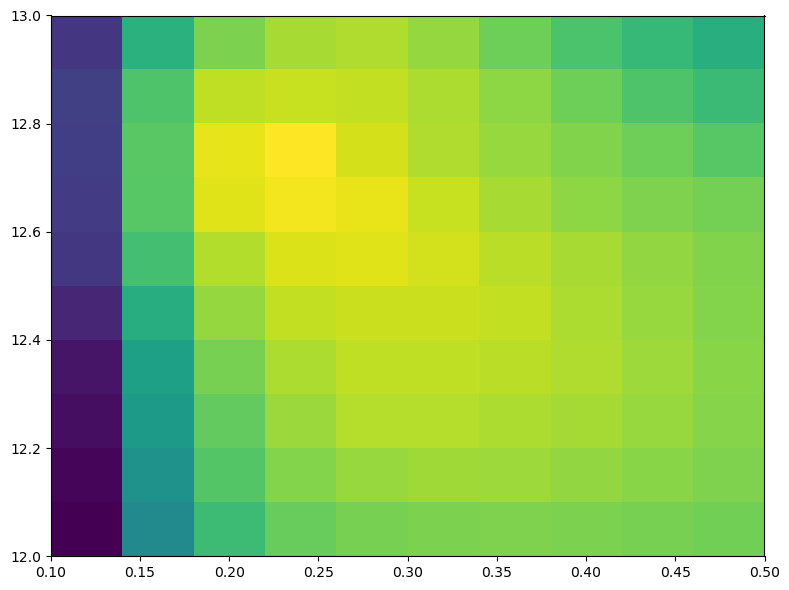

In [16]:

# === 5. Fix beta_DM and xi_DM，展示 mu vs sigma 的 2D 平面 ===
beta_fixed = 2.0
xi_fixed   = 0.0

# 构造二维网格点
MU, SIGMA = np.meshgrid(mu_grid, sigma_grid, indexing='ij')
points_2d = np.stack([MU.ravel(), SIGMA.ravel(), 
                      np.full(MU.size, beta_fixed), 
                      np.full(MU.size, xi_fixed)], axis=-1)

A_interp_vals = A_interp(points_2d).reshape(MU.shape)

# === 6. 可视化 ===
plt.figure(figsize=(8, 6))
im = plt.imshow(
    A_interp_vals,
    extent=[sigma_grid[0], sigma_grid[-1], mu_grid[0], mu_grid[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)
# plt.colorbar(im, label=r"$A_{\rm phys}$")
# plt.xlabel(r"$\sigma_{\rm DM}$")
# plt.ylabel(r"$\mu_{\rm DM}$")
# plt.title(rf"$A_{\rm phys}(\mu, \sigma)$ at $\beta={beta_fixed}, \xi={xi_fixed}$")
plt.tight_layout()
plt.show()